
# Carbon Emissions - NBEATS (Neural Basis Expansion Analyis for Interpretable Time Series.)

https://towardsdatascience.com/n-beats-unleashed-deep-forecasting-using-neural-basis-expansion-analysis-in-python-343dd6307010



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Load specific forecasting tools
from darts import TimeSeries, concatenate
from darts.models import NBEATSModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import time
from pylab import rcParams
import datetime

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
# Size of all plots
rcParams['figure.figsize'] = 12,6

from os import path 

/home/sipho/.pyenv/versions/3.10.6/envs/CO2_Emission_Indicator/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EDA: Data Overview

In [2]:
#Import Monthly Data for CO2 from 2000 - 2021 
co2_monthly_data_file_path = path.join("..", "raw_data", "CO2_Monthly_2000_2021.xlsx")
df_co2 = pd.read_excel(co2_monthly_data_file_path, sheet_name= 2, usecols="A:BE", skiprows=9)

In [3]:
df_co2.head()

IPCC_annex       C_group_IM24_sh Country_code_A3   Name Substance  Year  \
0  Non-Annex_I  Rest Central America             ABW  Aruba       CO2  2000   
1  Non-Annex_I  Rest Central America             ABW  Aruba       CO2  2001   
2  Non-Annex_I  Rest Central America             ABW  Aruba       CO2  2002   
3  Non-Annex_I  Rest Central America             ABW  Aruba       CO2  2003   
4  Non-Annex_I  Rest Central America             ABW  Aruba       CO2  2004   

          Jan         Feb         Mar         Apr         May         Jun  \
0   75.033577   77.599501   81.692956   79.657333   86.673927   78.173485   
1   77.059294   79.352561   83.946625   81.483107   88.966370   82.555282   
2   79.571167   80.777681   85.597256   83.685217   91.064551   83.701423   
3  102.868730  106.268702  114.549487  109.726618  121.908291  110.957630   
4  107.690365  110.753316  116.594683  111.111746  121.936352  110.681718   

          Jul         Aug         Sep         Oct         Nov         Dec  
0   79.360300   79.175078   77.199767   79.514418   77.600070   79.307682  
1   83.105237   81.294777   77.966059   81.675761   79.002588   80.758753  
2   84.069834   82.720519   79.560301   82.789217   80.485608   82.489015  
3  109.637020  106.824427   97.563781  101.397025  101.197493  105.571883  
4  111.957543  110.971074  105.578674  110.857518  108.447994  112.058260

In [4]:
# Drop irrelevant columns
df_raw = df_co2.drop(['IPCC_annex', 'IPCC_annex', 'Country_code_A3', 'C_group_IM24_sh', 'Substance'], axis=1)
df_raw.head()

Name  Year         Jan         Feb         Mar         Apr         May  \
0  Aruba  2000   75.033577   77.599501   81.692956   79.657333   86.673927   
1  Aruba  2001   77.059294   79.352561   83.946625   81.483107   88.966370   
2  Aruba  2002   79.571167   80.777681   85.597256   83.685217   91.064551   
3  Aruba  2003  102.868730  106.268702  114.549487  109.726618  121.908291   
4  Aruba  2004  107.690365  110.753316  116.594683  111.111746  121.936352   

          Jun         Jul         Aug         Sep         Oct         Nov  \
0   78.173485   79.360300   79.175078   77.199767   79.514418   77.600070   
1   82.555282   83.105237   81.294777   77.966059   81.675761   79.002588   
2   83.701423   84.069834   82.720519   79.560301   82.789217   80.485608   
3  110.957630  109.637020  106.824427   97.563781  101.397025  101.197493   
4  110.681718  111.957543  110.971074  105.578674  110.857518  108.447994   

          Dec  
0   79.307682  
1   80.758753  
2   82.489015  
3  105.571883  
4  112.058260

## EDA: Feature Engineering

In [5]:
df = df_raw.copy()
df_melt = pd.melt(frame=df, id_vars=['Name','Year'], var_name='Month', value_name='CO2')
df_melt.head(5)

Name  Year Month         CO2
0  Aruba  2000   Jan   75.033577
1  Aruba  2001   Jan   77.059294
2  Aruba  2002   Jan   79.571167
3  Aruba  2003   Jan  102.868730
4  Aruba  2004   Jan  107.690365

In [6]:
df = df_melt.replace({'Month' : {'Jan' : '1', 
                                            'Feb' : '2', 
                                            'Mar' : '3',
                                            'Apr' : '4', 
                                            'May' : '5', 
                                            'Jun' : '6',
                                            'Jul' : '7', 
                                            'Aug' : '8', 
                                            'Sep' : '9',
                                            'Oct' : '10', 
                                            'Nov' : '11', 
                                            'Dec' : '12',
                                            }})

In [7]:
df

Name  Year Month          CO2
0         Aruba  2000     1    75.033577
1         Aruba  2001     1    77.059294
2         Aruba  2002     1    79.571167
3         Aruba  2003     1   102.868730
4         Aruba  2004     1   107.690365
...         ...   ...   ...          ...
55435  Zimbabwe  2017    12  2297.788812
55436  Zimbabwe  2018    12  2497.723869
55437  Zimbabwe  2019    12  2414.406294
55438  Zimbabwe  2020    12  2434.758304
55439  Zimbabwe  2021    12  2600.251380

[55440 rows x 4 columns]

In [8]:
# Adding day column for date
df['day'] = 1

# Create column in datetime data type
df['date'] = pd.to_datetime(df[['Year','Month','day']])
df.head()

Name  Year Month         CO2  day       date
0  Aruba  2000     1   75.033577    1 2000-01-01
1  Aruba  2001     1   77.059294    1 2001-01-01
2  Aruba  2002     1   79.571167    1 2002-01-01
3  Aruba  2003     1  102.868730    1 2003-01-01
4  Aruba  2004     1  107.690365    1 2004-01-01

In [9]:
# drop unnecesary / redundant data 
df.drop(labels=['Month','Year','day'],axis=1,inplace=True)
df=df.rename(columns={"Name":"country"})
df.tail()

country          CO2       date
55435  Zimbabwe  2297.788812 2017-12-01
55436  Zimbabwe  2497.723869 2018-12-01
55437  Zimbabwe  2414.406294 2019-12-01
55438  Zimbabwe  2434.758304 2020-12-01
55439  Zimbabwe  2600.251380 2021-12-01

In [10]:
# pivot dataset to have better appreciation of all time-series per country

df_pivot = df.pivot(index='date', columns = 'country', values='CO2')
df_pivot = df_pivot.sort_index()

In [11]:
df_pivot

country     Afghanistan     Albania       Algeria       Angola  Anguilla  \
date                                                                       
2000-01-01   411.205605  536.805847   9286.794249  2759.198572  1.173216   
2000-02-01   411.687675  442.626571   7919.409553  2772.074092  1.220952   
2000-03-01   379.131203  443.304982   6522.584687  2886.074406  1.283940   
2000-04-01   234.927793  339.885503   6455.933956  2951.142688  1.313214   
2000-05-01   178.181973  320.851299   6393.552543  2876.712090  1.340777   
...                 ...         ...           ...          ...       ...   
2021-08-01   780.320662  412.870718  12891.255181  3865.626373  2.171800   
2021-09-01   968.896350  434.548085  12759.182812  4167.326267  2.155464   
2021-10-01  1213.943871  465.194491  13302.128875  4429.510466  2.261583   
2021-11-01  1267.068503  509.187260  15076.819484  4178.308051  2.161192   
2021-12-01  1242.944821  546.465286  20465.195149  3891.853516  1.998979   

country     Antigua and Barbuda     Argentina     Armenia       Aruba  \
date                                                                    
2000-01-01            43.977761  12852.296777  444.228731   75.033577   
2000-02-01            43.384216  13215.394032  411.458205   77.599501   
2000-03-01            43.074409  15751.487901  372.663370   81.692956   
2000-04-01            39.658795  17082.707585  288.899188   79.657333   
2000-05-01            37.205220  17747.260115  265.560380   86.673927   
...                         ...           ...         ...         ...   
2021-08-01            53.567481  22830.892718  377.850863  110.469996   
2021-09-01            70.593452  25357.579709  394.362278   97.561458   
2021-10-01            45.103499  25747.487706  593.980264  120.410782   
2021-11-01            52.242703  21975.039468  700.283066  111.613946   
2021-12-01            49.296613  18849.683382  772.804359  105.266762   

country        Australia  ...      Uruguay    Uzbekistan    Vanuatu  \
date                      ...                                         
2000-01-01  33445.637281  ...   491.031419  17983.140776  15.549737   
2000-02-01  33440.827740  ...   487.431120  15807.366373  15.703437   
2000-03-01  35268.973813  ...   557.494329  13127.803418  16.481137   
2000-04-01  37030.869252  ...   628.676843   7211.520414  16.653836   
2000-05-01  37188.697924  ...   828.251463   6815.395118  16.282884   
...                  ...  ...          ...           ...        ...   
2021-08-01  35518.047637  ...  2099.950008   7042.813194  24.129881   
2021-09-01  33615.606705  ...  2059.674589   7596.423631  24.766045   
2021-10-01  35369.412152  ...  1946.890087  10043.892017  26.604877   
2021-11-01  34793.342664  ...  1652.187033  12129.077565  25.564027   
2021-12-01  34376.272345  ...  1630.793030  15020.895433  23.985906   

country        Venezuela      Viet Nam  Virgin Islands_British  \
date                                                             
2000-01-01  12458.041962  27010.380425               10.694783   
2000-02-01  12289.161598  21039.375626               11.082876   
2000-03-01  12597.921977  13128.990322               11.722635   
2000-04-01  12761.065486  14478.141450               11.301695   
2000-05-01  12367.755499  11934.916062               12.532093   
...                  ...           ...                     ...   
2021-08-01   8336.419679  33222.568142               16.357275   
2021-09-01   9006.448442  36430.624437               14.521154   
2021-10-01   8712.067916  40264.717428               17.823234   
2021-11-01   9063.972724  37112.560596               16.562422   
2021-12-01   8979.794629  43113.471414               15.698311   

country     Western Sahara        Yemen       Zambia     Zimbabwe  
date                                                               
2000-01-01       40.331648  1189.182467   968.754333  2575.343179  
2000-02-01       18.685228  1172.048922   980.393308  2577.451899  
2000-0

In [12]:
train_df = df_pivot.loc['2000-01-01':'2018-12-01'] 
test_df = df_pivot.loc['2019-01-01':'2021-12-01']

In [13]:
train_df

country     Afghanistan     Albania       Algeria       Angola  Anguilla  \
date                                                                       
2000-01-01   411.205605  536.805847   9286.794249  2759.198572  1.173216   
2000-02-01   411.687675  442.626571   7919.409553  2772.074092  1.220952   
2000-03-01   379.131203  443.304982   6522.584687  2886.074406  1.283940   
2000-04-01   234.927793  339.885503   6455.933956  2951.142688  1.313214   
2000-05-01   178.181973  320.851299   6393.552543  2876.712090  1.340777   
...                 ...         ...           ...          ...       ...   
2018-08-01   799.587222  466.877599  13052.085384  3780.781389  2.411434   
2018-09-01   949.267379  490.111693  12937.511227  4131.179579  2.393999   
2018-10-01  1168.745310  522.357465  13481.688698  4417.166353  2.514275   
2018-11-01  1255.579082  569.822635  15136.316730  4130.283320  2.403458   
2018-12-01  1280.274298  610.564026  20136.275648  3819.055378  2.222753   

country     Antigua and Barbuda     Argentina     Armenia       Aruba  \
date                                                                    
2000-01-01            43.977761  12852.296777  444.228731   75.033577   
2000-02-01            43.384216  13215.394032  411.458205   77.599501   
2000-03-01            43.074409  15751.487901  372.663370   81.692956   
2000-04-01            39.658795  17082.707585  288.899188   79.657333   
2000-05-01            37.205220  17747.260115  265.560380   86.673927   
...                         ...           ...         ...         ...   
2018-08-01            58.774155  22760.401169  338.033224  116.533541   
2018-09-01            77.454877  24728.275674  354.982074  102.884173   
2018-10-01            49.482509  24849.453358  524.701250  127.018172   
2018-11-01            57.316469  21377.399870  613.451346  117.723425   
2018-12-01            54.084188  18572.686074  672.148373  111.008460   

country        Australia  ...      Uruguay    Uzbekistan    Vanuatu  \
date                      ...                                         
2000-01-01  33445.637281  ...   491.031419  17983.140776  15.549737   
2000-02-01  33440.827740  ...   487.431120  15807.366373  15.703437   
2000-03-01  35268.973813  ...   557.494329  13127.803418  16.481137   
2000-04-01  37030.869252  ...   628.676843   7211.520414  16.653836   
2000-05-01  37188.697924  ...   828.251463   6815.395118  16.282884   
...                  ...  ...          ...           ...        ...   
2018-08-01  39604.847662  ...  2064.955876   6538.300066  23.572059   
2018-09-01  37484.352791  ...  1999.597380   7034.154610  24.205720   
2018-10-01  39451.586933  ...  1870.375310   9358.765117  25.977546   
2018-11-01  38764.285458  ...  1594.497950  11396.979120  24.966086   
2018-12-01  38233.674732  ...  1591.728496  14278.188405  23.436987   

country        Venezuela      Viet Nam  Virgin Islands_British  \
date                                                             
2000-01-01  12458.041962  27010.380425               10.694783   
2000-02-01  12289.161598  21039.375626               11.082876   
2000-03-01  12597.921977  13128.990322               11.722635   
2000-04-01  12761.065486  14478.141450               11.301695   
2000-05-01  12367.755499  11934.916062               12.532093   
...                  ...           ...                     ...   
2018-08-01  10996.710608  29289.874343               22.171581   
2018-09-01  11916.052894  32935.995376               19.636020   
2018-10-01  11458.356052  36757.363607               24.162558   
2018-11-01  11925.891900  33498.523477               22.428288   
2018-12-01  11813.968636  42650.826438               21.215658   

country     Western Sahara        Yemen       Zambia     Zimbabwe  
date                                                               
2000-01-01       40.331648  1189.182467   968.754333  2575.343179  
2000-02-01       18.685228  1172.048922   980.393308  2577.451899  
2000-0

## EDA PreProcessing

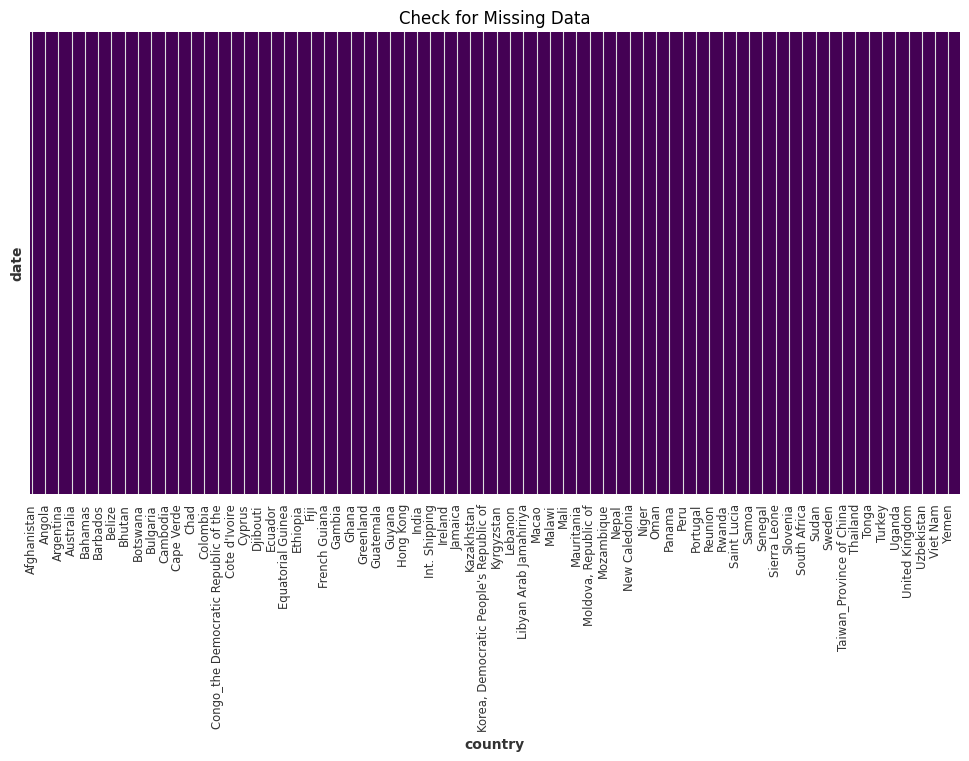

In [14]:
#Use heatmap to identify mising data
ax = plt.axes()
ax.set_title('Check for Missing Data')
sns.heatmap(df_pivot.isnull(),yticklabels=False,cbar=False,cmap='viridis',ax=ax);

In [15]:
df_pivot.isnull().sum().sort_values(ascending=False).head(10)

country
Afghanistan             0
Saint Helena            0
Netherlands             0
Netherlands Antilles    0
New Caledonia           0
New Zealand             0
Nicaragua               0
Niger                   0
Nigeria                 0
Norway                  0
dtype: int64

In [16]:
# train_df without null values.
df = train_df.melt(var_name='country',value_name='co2',ignore_index=False)

In [17]:
df

country          co2
date                                
2000-01-01  Afghanistan   411.205605
2000-02-01  Afghanistan   411.687675
2000-03-01  Afghanistan   379.131203
2000-04-01  Afghanistan   234.927793
2000-05-01  Afghanistan   178.181973
...                 ...          ...
2018-08-01     Zimbabwe  3505.286372
2018-09-01     Zimbabwe  2701.580067
2018-10-01     Zimbabwe  2807.629639
2018-11-01     Zimbabwe  2612.459802
2018-12-01     Zimbabwe  2497.723869

[47880 rows x 2 columns]

In [18]:
#Create encoded column based on lat_long
label_encoder = LabelEncoder()
df['country2'] = df['country'].astype('string')
df['location'] = label_encoder.fit_transform(df['country2'])
df = df.sort_index()

In [19]:
df.head()

country           co2              country2  location
date                                                                          
2000-01-01           Afghanistan    411.205605           Afghanistan         0
2000-01-01           Netherlands  18798.186455           Netherlands       133
2000-01-01  Netherlands Antilles    459.342025  Netherlands Antilles       134
2000-01-01         New Caledonia    186.384884         New Caledonia       135
2000-01-01           New Zealand   2954.824840           New Zealand       136

In [20]:
df[['country','location']].sort_values(by='location')

country  location
date                             
2000-01-01  Afghanistan         0
2010-01-01  Afghanistan         0
2009-12-01  Afghanistan         0
2003-09-01  Afghanistan         0
2009-11-01  Afghanistan         0
...                 ...       ...
2013-01-01     Zimbabwe       209
2012-02-01     Zimbabwe       209
2009-04-01     Zimbabwe       209
2007-10-01     Zimbabwe       209
2018-12-01     Zimbabwe       209

[47880 rows x 2 columns]

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47880 entries, 2000-01-01 to 2018-12-01
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   country   47880 non-null  object 
 1   co2       47880 non-null  float64
 2   country2  47880 non-null  string 
 3   location  47880 non-null  int64  
dtypes: float64(1), int64(1), object(1), string(1)
memory usage: 1.8+ MB


In [22]:
df.describe().transpose()

count          mean           std       min         25%  \
co2       47880.0  15497.605907  67059.963195  0.140815  310.766278   
location  47880.0    104.500000     60.621724  0.000000   52.000000   

                  50%          75%           max  
co2       1701.891882  6773.287434  1.152663e+06  
location   104.500000   157.000000  2.090000e+02

In [23]:
df1 = df[['co2','location']]

In [24]:
df1.shape

(47880, 2)

In [25]:
df1

co2  location
date                              
2000-01-01    411.205605         0
2000-01-01  18798.186455       133
2000-01-01    459.342025       134
2000-01-01    186.384884       135
2000-01-01   2954.824840       136
...                  ...       ...
2018-12-01    235.873740       134
2018-12-01  17914.085800       133
2018-12-01   9546.474523       132
2018-12-01  71541.900662       103
2018-12-01   2497.723869       209

[47880 rows x 2 columns]

In [26]:
#how many data points we have per time-series?
len(df1.pivot(columns = 'location', values='co2')[0])

228

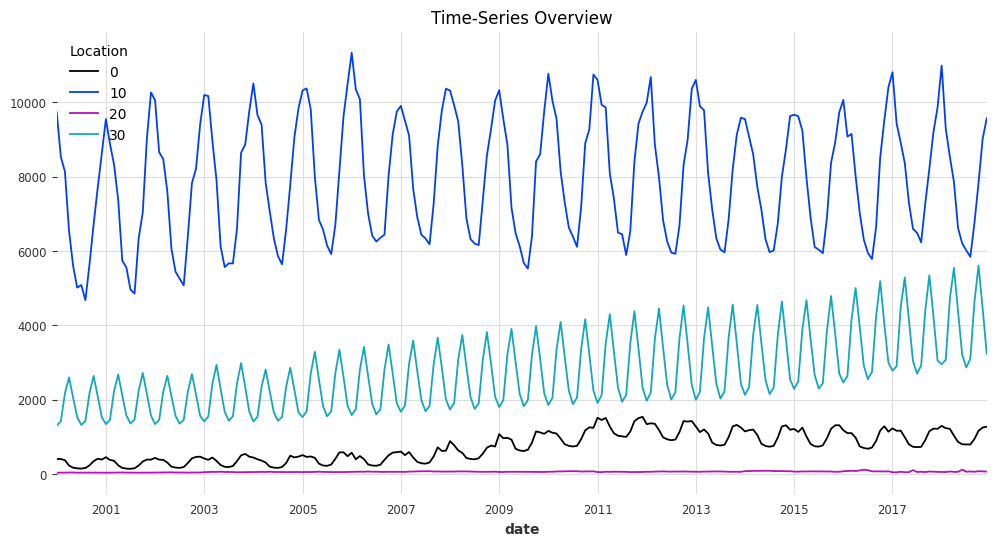

In [27]:
df1.pivot(columns = 'location', values='co2')[0].plot()
df1.pivot(columns = 'location', values='co2')[10].plot()
df1.pivot(columns = 'location', values='co2')[20].plot()
df1.pivot(columns = 'location', values='co2')[30].plot()
plt.legend(title='Location')
plt.title('Time-Series Overview');

In [28]:
# Encoded locations available
np.sort(df1['location'].unique())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [29]:
print('********** Visualize darts Time-series data *************')
TimeSeries.from_dataframe(df1.pivot(columns='location',values='co2')[[0]].reset_index().rename_axis(None, axis=1),time_col='date')

********** Visualize darts Time-series data *************


<TimeSeries (DataArray) (date: 228, component: 1, sample: 1)>
array([[[ 411.20560457]],

       [[ 411.68767513]],

       [[ 379.13120304]],

       [[ 234.92779257]],

       [[ 178.18197302]],

       [[ 159.89071013]],

       [[ 154.2602413 ]],

       [[ 168.65512814]],

       [[ 241.05344314]],

       [[ 350.90775473]],

...

       [[1222.06383889]],

       [[1039.08571592]],

       [[ 870.07783978]],

       [[ 808.06694541]],

       [[ 803.09795588]],

       [[ 799.58722232]],

       [[ 949.26737941]],

       [[1168.74530999]],

       [[1255.57908164]],

       [[1280.27429829]]])
Coordinates:
  * date       (date) datetime64[ns] 2000-01-01 2000-02-01 ... 2018-12-01
  * component  (component) <U1 '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

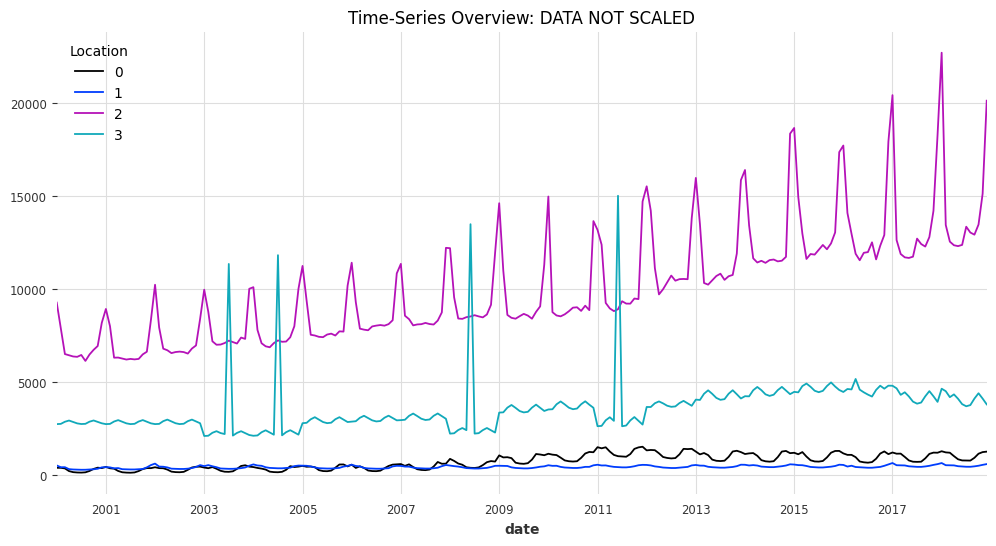

In [30]:
# Plot some of the time-series data. It was noticed data needs to be scaled.
df1.pivot(columns = 'location', values='co2')[0].plot()
df1.pivot(columns = 'location', values='co2')[1].plot()
df1.pivot(columns = 'location', values='co2')[2].plot()
df1.pivot(columns = 'location', values='co2')[3].plot()
plt.legend(title='Location')
plt.title('Time-Series Overview: DATA NOT SCALED');

In [31]:
scaler_co2 = Scaler()

In [32]:
#This loop is used to create two lists: 
    #scaled time-series per location and 
    # unscaled Time-Series per location 
# Also, we convert to timeseries data type from darts)
#This is done so we can feed the model with the scaled data.
location_list = []
location_list_transf = []
for location in np.sort(df1['location'].unique()).tolist():
    location_list.append(TimeSeries.from_dataframe(df1.pivot(columns='location',values='co2')[[location]].reset_index().rename_axis(None, axis=1),time_col='date'))
    location_list_transf.append(scaler_co2.fit_transform(TimeSeries.from_dataframe(df1.pivot(columns='location',values='co2')[[location]].reset_index().rename_axis(None, axis=1),time_col='date')))


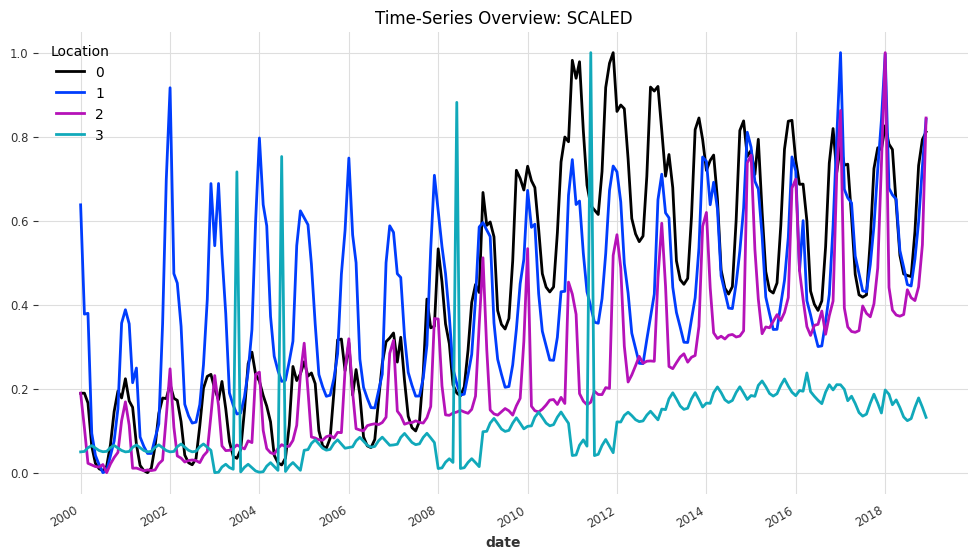

In [33]:
location_list_transf[0].plot()
location_list_transf[1].plot()
location_list_transf[2].plot()
location_list_transf[3].plot()
plt.legend(title='Location')
plt.title('Time-Series Overview: SCALED');

## Data Modeling


In [34]:
# The model will be saved so it can be used in the future. Therefore, we set the following variables:

load = False
SAVE = "\_NBEATS_model_Rev01.pth.tar" #filename
mpath = os.path.abspath(os.getcwd()) + SAVE # path and file name to save the model
print(os.getcwd())

/home/sipho/code/L-Fandangle042/CO2_Emission_Indicator/notebooks


### 1. Create NBEATS instance (a generic model for all time-series)
### 2. Fit the model with all time-series in df
### 3. Save / load model for future use


In [35]:
# training: load a saved model or (re)train
if load:
    print("have loaded a previously saved model from disk:" + mpath)
    model = NBEATSModel.load_model(mpath)                            # load previously model from disk
else:
    model = NBEATSModel(input_chunk_length=48,
                        output_chunk_length=12,                        
                        random_state=0)
    model.fit(location_list_transf,verbose=True,epochs=10)
    print("have saved the model after training:", mpath)
    model.save(mpath)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.4 M 
---------------------------------------------------
6.4 M     Trainable params
1.6 K     Non-trainable params
6.4 M     Total params
25.542    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 1110/1110 [10:22<00:00,  1.78it/s, train_loss=0.00412]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1110/1110 [10:22<00:00,  1.78it/s, train_loss=0.00412]
have saved the model after training: /home/sipho/code/L-Fandangle042/CO2_Emission_Indicator/notebooks\_NBEATS_model_Rev01.pth.tar


### 4. Evaluate model's performance
### 5. Forecast on some locations and plot results


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


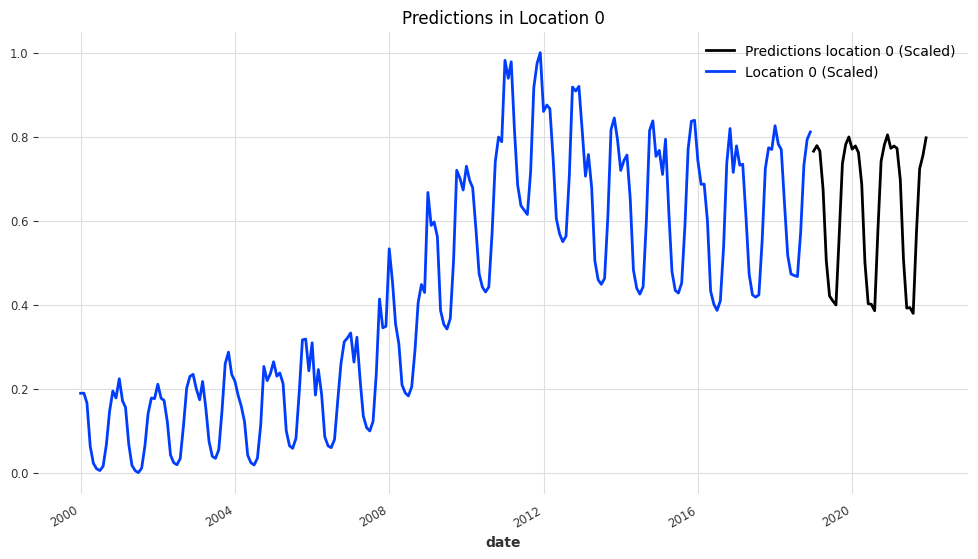

In [36]:
model.predict(n=36,series=location_list_transf[0]).plot(label='Predictions location 0 (Scaled)')
location_list_transf[0].plot(label='Location 0 (Scaled)')
plt.title('Predictions in Location 0');

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


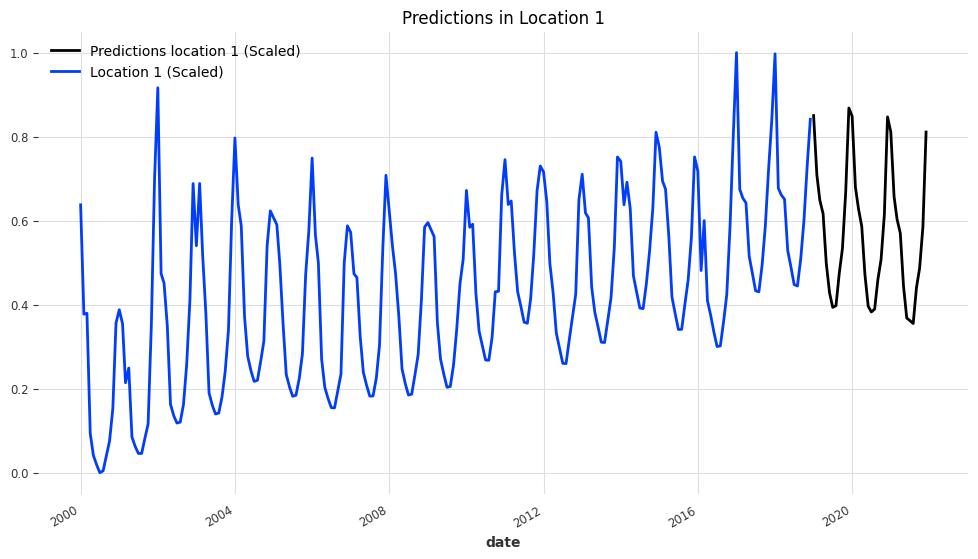

In [37]:
model.predict(n=36,series=location_list_transf[1]).plot(label='Predictions location 1 (Scaled)')
location_list_transf[1].plot(label='Location 1 (Scaled)')
plt.title('Predictions in Location 1');

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


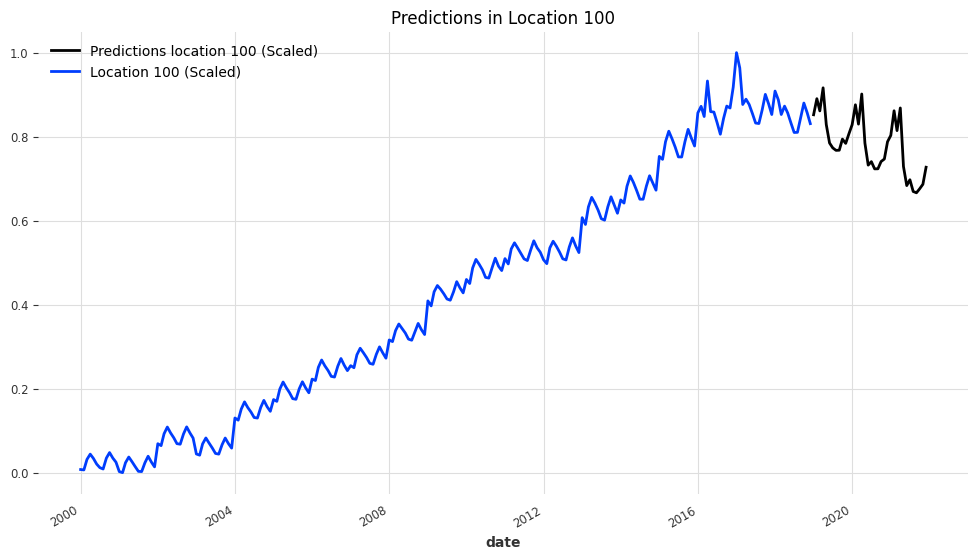

In [38]:
model.predict(n=36,series=location_list_transf[100]).plot(label='Predictions location 100 (Scaled)')
location_list_transf[100].plot(label='Location 100 (Scaled)')
plt.title('Predictions in Location 100');

In [39]:
# Inverse transformation of time-series data

for location in range(df['location'].max()+1):
    scaler_co2.fit_transform(TimeSeries.from_dataframe(df1.pivot(columns='location',values='co2')[[location]].reset_index().rename_axis(None, axis=1),time_col='date'))
    if location == 0:
        predictions = scaler_co2.inverse_transform(model.predict(n=36,series=location_list_transf[location])).pd_dataframe()
    else:
        predictions[str(location)] = scaler_co2.inverse_transform(model.predict(n=36,series=location_list_transf[location])).pd_dataframe()


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.93it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


In [40]:
predictions.head()

component             0           1             2            3         4  \
date                                                                       
2019-01-01  1216.516149  613.748255  20194.354733  4002.279882  2.001881   
2019-02-01  1234.988655  562.539029  14837.396557  4267.864273  2.134701   
2019-03-01  1217.469761  540.869149  12435.006444  3812.218851  2.244150   
2019-04-01  1088.522488  529.083386  12144.862600  4357.085741  2.351985   
2019-05-01   853.503400  486.423865  11877.686068  3877.514270  2.261028   

component           5             6           7           8             9  \
date                                                                        
2019-01-01  60.568912  17383.781163  732.066009  104.352348  38478.066777   
2019-02-01  78.676339  18823.778502  707.471428  107.560875  38454.792270   
2019-03-01  71.543501  22819.094118  608.214187  113.909040  40234.014724   
2019-04-01  67.053187  26353.081147  518.592388  104.521185  40255.634142   
2019-05-01  67.242150  25607.532509  396.866601  112.412096  38694.250721   

component   ...          200           201        202           203  \
date        ...                                                       
2019-01-01  ...  1357.735197  14244.558417  28.153279  12095.966456   
2019-02-01  ...  1411.559787  13416.354160  32.055736  12631.847843   
2019-03-01  ...  1620.729553  10712.260304  24.779207  12486.673966   
2019-04-01  ...  1935.100713   8257.538236  23.139789  12456.478851   
2019-05-01  ...  1990.883581   6662.024339  21.934940  11951.098236   

component            204        205        206          207          208  \
date                                                                       
2019-01-01  37273.012641  18.826666  22.655857  1565.149704  1811.959800   
2019-02-01  35184.872736  20.041313  20.083482  1174.485936  1883.915026   
2019-03-01  37418.987565  21.989628  18.086445   992.017021  1385.550295   
2019-04-01  39695.841733  21.609751  18.090839   959.088368  2046.082012   
2019-05-01  34176.303140  21.745288  18.512329   926.100477  1763.701044   

component           209  
date                     
2019-01-01  2237.110548  
2019-02-01  2255.004250  
2019-03-01  1815.016763  
2019-04-01  2806.463811  
2019-05-01  2688.485372  

[5 rows x 210 columns]

In [41]:
predictions = predictions.melt(value_vars=predictions.iloc[:,:].columns,var_name='location',value_name='co2',ignore_index=False)

In [42]:
predictions['location'] = predictions['location'].astype(int)

In [43]:
predictions.head()

location          co2
date                             
2019-01-01         0  1216.516149
2019-02-01         0  1234.988655
2019-03-01         0  1217.469761
2019-04-01         0  1088.522488
2019-05-01         0   853.503400

Forecasting with TEST dataset

### 7. Test the model perfomance

In [44]:
test_df.head()

country     Afghanistan     Albania       Algeria       Angola  Anguilla  \
date                                                                       
2019-01-01  1210.144725  645.551063  23686.453861  4763.573017  2.038197   
2019-02-01  1155.267672  529.683414  13746.626004  4637.164427  2.113027   
2019-03-01  1173.894540  523.577796  12776.053820  4348.167013  2.256234   
2019-04-01  1012.841588  520.099673  12578.535376  4505.162923  2.305245   
2019-05-01   826.086350  475.559559  12532.237818  4264.271149  2.350536   

country     Antigua and Barbuda     Argentina     Armenia       Aruba  \
date                                                                    
2019-01-01           107.554946  18114.132240  873.992544   96.606922   
2019-02-01            81.444135  18485.065009  803.272146   94.880374   
2019-03-01            92.244140  23795.071365  670.272878  118.138413   
2019-04-01            58.596703  26959.355416  558.650826  100.044742   
2019-05-01            79.909713  26097.676151  452.658443  102.001070   

country        Australia  ...      Uruguay    Uzbekistan    Vanuatu  \
date                      ...                                         
2019-01-01  39333.721145  ...  1541.548119  15425.319059  36.717726   
2019-02-01  38024.820714  ...  1452.351340  14591.342476  34.306715   
2019-03-01  39374.353791  ...  1725.702443  12258.691983  25.332941   
2019-04-01  38873.584870  ...  2073.646637   9159.879620  24.684895   
2019-05-01  38675.528739  ...  2139.595867   7760.333704  24.480655   

country        Venezuela      Viet Nam  Virgin Islands_British  \
date                                                             
2019-01-01  12705.966582  33438.258509               14.488551   
2019-02-01  11174.245557  32702.648968               14.243492   
2019-03-01  11526.383968  38058.829990               17.570890   
2019-04-01  10161.004472  38643.068742               14.970772   
2019-05-01  10481.918280  36021.310864               15.237328   

country     Western Sahara        Yemen       Zambia     Zimbabwe  
date                                                               
2019-01-01       23.972546   879.780030  1946.166789  2393.657272  
2019-02-01       17.344780  1109.149207  1929.269830  2367.394602  
2019-03-01       18.395063  1001.473890  2103.928813  2537.242204  
2019-04-01       17.333871   942.099714  2221.905048  2594.299137  
2019-05-01       17.448553   924.927419  2071.567492  2831.725584  

[5 rows x 210 columns]

In [45]:
# df without null values.
test_df_melt = test_df.melt(var_name='country',value_name='co2',ignore_index=False)

In [46]:
test_df_melt

country          co2
date                                
2019-01-01  Afghanistan  1210.144725
2019-02-01  Afghanistan  1155.267672
2019-03-01  Afghanistan  1173.894540
2019-04-01  Afghanistan  1012.841588
2019-05-01  Afghanistan   826.086350
...                 ...          ...
2021-08-01     Zimbabwe  3609.101329
2021-09-01     Zimbabwe  2934.054233
2021-10-01     Zimbabwe  3124.576899
2021-11-01     Zimbabwe  2821.273832
2021-12-01     Zimbabwe  2600.251380

[7560 rows x 2 columns]

In [47]:
#Create encoded column based on country
label_encoder = LabelEncoder()
test_df_melt['country2'] = test_df_melt['country'].astype('string')
test_df_melt['location'] = label_encoder.fit_transform(test_df_melt['country2'])
test_df_melt = test_df_melt.sort_index()

In [48]:
test_df_melt

country           co2     country2  location
date                                                        
2019-01-01  Afghanistan   1210.144725  Afghanistan         0
2019-01-01      Morocco   9847.685853      Morocco       128
2019-01-01   Mozambique   2969.267568   Mozambique       129
2019-01-01     Barbados    253.448283     Barbados        15
2019-01-01      Myanmar   8414.214344      Myanmar       130
...                 ...           ...          ...       ...
2021-12-01      Namibia    351.392175      Namibia       131
2021-12-01      Myanmar  31871.561488      Myanmar       130
2021-12-01   Mozambique   3001.563827   Mozambique       129
2021-12-01      Nigeria  50061.358950      Nigeria       139
2021-12-01     Zimbabwe   2600.251380     Zimbabwe       209

[7560 rows x 4 columns]

In [49]:
df_test = test_df_melt[['country','location', 'co2']]
df_test.head()

country  location          co2
date                                          
2019-01-01  Afghanistan         0  1210.144725
2019-01-01      Morocco       128  9847.685853
2019-01-01   Mozambique       129  2969.267568
2019-01-01     Barbados        15   253.448283
2019-01-01      Myanmar       130  8414.214344

In [50]:
query = []
for coor in range(len(df_test)):
    query.append(df[df['country'] == df_test['country'][coor]]['location'].unique()[0])
df_test['location'] = query

In [51]:
results = pd.merge(left=df_test, right=predictions, how='left', on=['date','location'])

In [52]:
results

country  location         co2_x         co2_y
date                                                         
2019-01-01  Afghanistan         0   1210.144725   1216.516149
2019-01-01      Morocco       128   9847.685853   8556.126511
2019-01-01   Mozambique       129   2969.267568   2891.600567
2019-01-01     Barbados        15    253.448283    163.171029
2019-01-01      Myanmar       130   8414.214344  18019.808429
...                 ...       ...           ...           ...
2021-12-01      Namibia       131    351.392175    319.833804
2021-12-01      Myanmar       130  31871.561488  15737.503949
2021-12-01   Mozambique       129   3001.563827   4239.547246
2021-12-01      Nigeria       139  50061.358950  46073.380515
2021-12-01     Zimbabwe       209   2600.251380   2246.799751

[7560 rows x 4 columns]

In [53]:
results = results.rename(columns=({'co2_x':'CO2 Actual', 'co2_y':'CO2 Predicted'}))
results

country  location    CO2 Actual  CO2 Predicted
date                                                          
2019-01-01  Afghanistan         0   1210.144725    1216.516149
2019-01-01      Morocco       128   9847.685853    8556.126511
2019-01-01   Mozambique       129   2969.267568    2891.600567
2019-01-01     Barbados        15    253.448283     163.171029
2019-01-01      Myanmar       130   8414.214344   18019.808429
...                 ...       ...           ...            ...
2021-12-01      Namibia       131    351.392175     319.833804
2021-12-01      Myanmar       130  31871.561488   15737.503949
2021-12-01   Mozambique       129   3001.563827    4239.547246
2021-12-01      Nigeria       139  50061.358950   46073.380515
2021-12-01     Zimbabwe       209   2600.251380    2246.799751

[7560 rows x 4 columns]

In [54]:
results.sort_values(by='location')

country  location   CO2 Actual  CO2 Predicted
date                                                         
2019-01-01  Afghanistan         0  1210.144725    1216.516149
2020-02-01  Afghanistan         0  1175.784780    1233.921984
2020-03-01  Afghanistan         0  1202.739882    1211.856183
2020-04-01  Afghanistan         0  1042.074478    1105.646889
2020-05-01  Afghanistan         0   846.274031     847.059403
...                 ...       ...          ...            ...
2019-04-01     Zimbabwe       209  2594.299137    2806.463811
2021-08-01     Zimbabwe       209  3609.101329    2420.890454
2020-10-01     Zimbabwe       209  2738.338014    2246.609829
2021-05-01     Zimbabwe       209  3190.817050    2277.482078
2021-12-01     Zimbabwe       209  2600.251380    2246.799751

[7560 rows x 4 columns]

In [55]:
import plotly.express as px

fig = px.line(results, x=results.index, y=["CO2 Actual", "CO2 Predicted"], color='country', width=1200, height=800, labels={'value': 'CO2 Emissions', 'variable': 'Data Type', 'country': 'Country'}, line_dash='variable')
fig.update_layout(title='CO2 Emissions Actual vs Predicted', xaxis_title='Year', yaxis_title='CO2 Emissions', legend_title='Data Type')
fig.show()


In [56]:
from sklearn.metrics import mean_squared_error

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(results['CO2 Actual'], results['CO2 Predicted']))

print('RMSE:', rmse)


RMSE: 11743.86582023648


In [57]:
# get the range of values in CO2 Actual
CO2_Actual_Min = results['CO2 Actual'].min() 
CO2_Actual_Max = results['CO2 Actual'].max() 

print('CO2 Actual min:', CO2_Actual_Min)
print('CO2 Actual max:', CO2_Actual_Max)
print('Range of values in CO2 Actual:', CO2_Actual_Max - CO2_Actual_Min)

CO2 Actual min: 0.16272368424982
CO2 Actual max: 1244488.7569666
Range of values in CO2 Actual: 1244488.5942429157
